>>> 1. Fetching Data & Aligning Dates...
    Data Shape: (378, 6)
>>> 2. Running Expanding Window HMM (Stabilized)...


100%|██████████| 318/318 [01:34<00:00,  3.37it/s]


>>> 3. Visualizing Regimes...


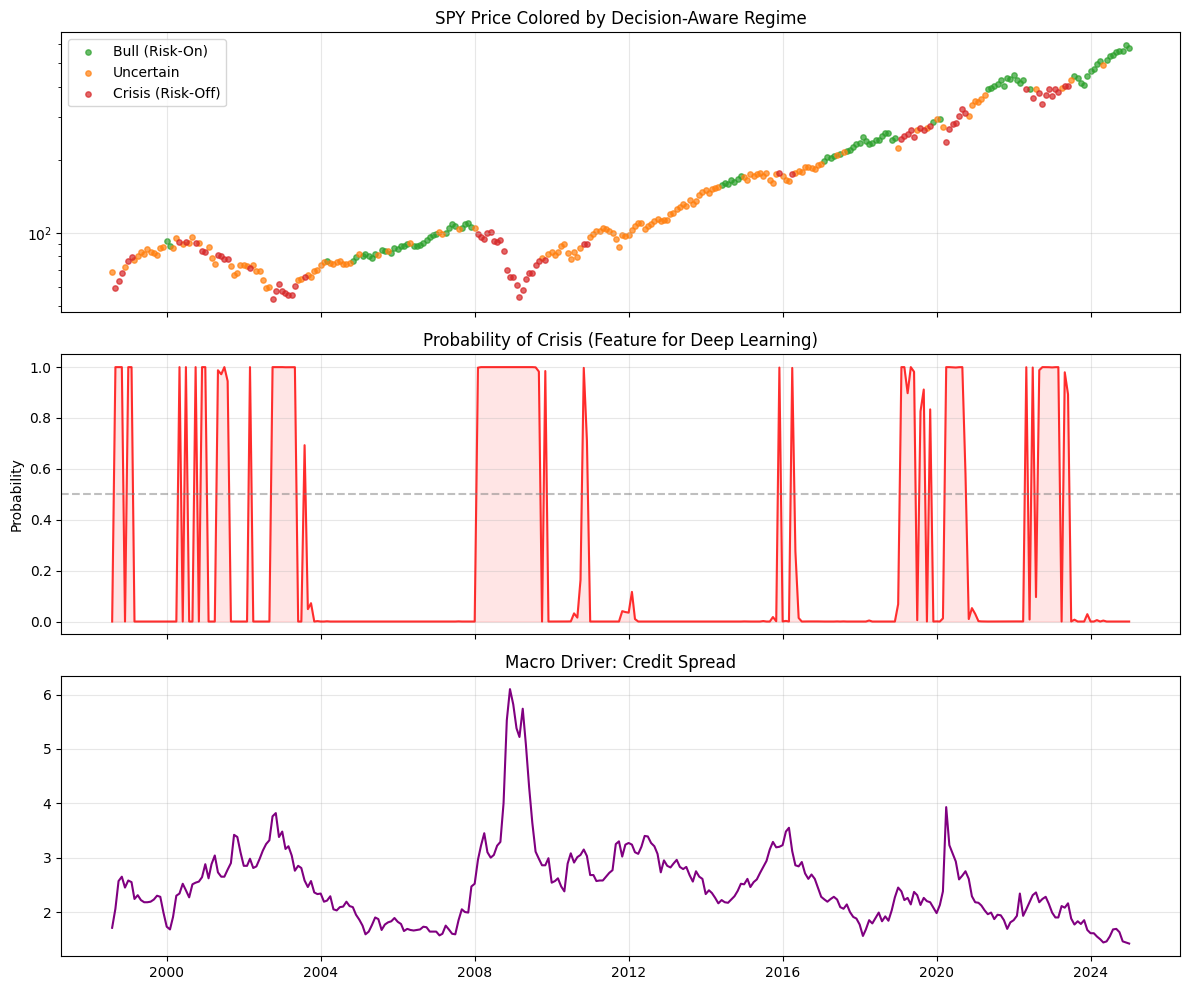


[Latest Regime Check]
                   SPY  Regime   Prob_Crisis
Date                                        
2024-08-31  553.570618     0.0  1.392590e-10
2024-09-30  563.469910     0.0  1.300624e-10
2024-10-31  560.154602     0.0  3.479274e-13
2024-11-30  593.558594     0.0  1.655698e-04
2024-12-31  577.334290     0.0  4.842645e-10


In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

class RobustRegimeClassifier:
    def __init__(self, start_date='1990-01-01', end_date='2024-12-31', min_window=60):
        self.start_date = start_date
        self.end_date = end_date
        self.min_window = min_window  # 초기 학습 데이터 길이 (개월)
        self.n_states = 3             # 0:Bull, 1:Uncertain, 2:Crisis

    def fetch_data(self):
        print(">>> 1. Fetching Data & Aligning Dates...")

        # A. Market Data (SPY)
        # auto_adjust=True: 배당락 등이 반영된 수정 주가 사용
        spy = yf.download('SPY', start=self.start_date, end=self.end_date, interval='1mo', progress=False, auto_adjust=True)['Close']
        if isinstance(spy, pd.DataFrame): spy = spy.iloc[:, 0]

        # [Date Alignment] 모든 날짜를 해당 월의 '마지막 날'로 통일하여 매칭 오류 방지
        spy.index = spy.index.to_period('M').to_timestamp('M')

        # Feature Eng
        returns = np.log(spy / spy.shift(1))
        volatility = returns.rolling(window=6).std()

        # B. Macro Data (FRED)
        # BAA10Y: Credit Spread (Crisis Indicator)
        # NFCI: Financial Conditions (Liquidity)
        fred_tickers = ['BAA10Y', 'T10Y3M', 'NFCI']
        macro = web.DataReader(fred_tickers, 'fred', self.start_date, self.end_date).resample('M').last()
        macro.index = macro.index.to_period('M').to_timestamp('M') # FRED 데이터도 월말로 통일

        # Merge
        df = pd.DataFrame({'SPY': spy, 'Returns': returns, 'Vol': volatility})
        # Macro 데이터 결합 (결측치는 이전 달 값으로 채움)
        df = df.join(macro).ffill().dropna()

        print(f"    Data Shape: {df.shape}")
        return df

    def run_expanding_window_hmm(self, df):
        print(">>> 2. Running Expanding Window HMM (Stabilized)...")

        regime_preds = []
        prob_preds = []

        feature_cols = ['Returns', 'Vol', 'BAA10Y']

        for t in tqdm(range(self.min_window, len(df))):

            # 1. Expanding Window
            train_data = df.iloc[:t+1].copy()
            X_train = train_data[feature_cols].values

            # Standardization
            means = X_train.mean(axis=0)
            stds = X_train.std(axis=0) + 1e-6
            X_scaled = (X_train - means) / stds

            # 2. Fit HMM (안정성 강화 설정 적용)
            best_score = -np.inf
            best_model = None

            # 시도 횟수 3회 -> 5회로 증가
            for _ in range(5):
                try:
                    model = GaussianHMM(
                        n_components=self.n_states,
                        covariance_type="diag",
                        n_iter=1000,
                        tol=1e-4,
                        min_covar=1e-3,
                        random_state=None # 매번 다른 랜덤 시드 사용
                    )
                    model.fit(X_scaled)

                    if model.score(X_scaled) > best_score:
                        best_score = model.score(X_scaled)
                        best_model = model
                except:
                    continue

            # 여전히 수렴 안 되면 가장 마지막에 시도한 모델이라도 사용 (None 방지)
            if best_model is None:
                best_model = model

            # 3. Predict
            hidden_states = best_model.predict(X_scaled)
            current_state = hidden_states[-1]
            current_probs = best_model.predict_proba(X_scaled)[-1]


            # --- 4. Dynamic State Re-ordering (Economist's Logic) ---
            state_scores = []
            for i in range(self.n_states):
           # m[0]: Scaled Returns
          # m[1]: Scaled Volatility
                # m[2]: Scaled Credit Spread (BAA10Y)
                m = best_model.means_[i]

                # [Economist's Formula]
                # 신용 위험(Spread)에 가중치를 높게 두어 "진짜 위기"를 식별
                # 변동성보다 신용 경색이 더 치명적인 구조적 위험이기 때문

                weight_spread = 0.5
                weight_vol = 0.3
                weight_ret = 0.2

                # Score 계산 (Standardized 된 값이므로 단위 걱정 없음)
                # Spread(+) + Vol(+) - Returns(-)
                score = (weight_spread * m[2]) + (weight_vol * m[1]) - (weight_ret * m[0])

                state_scores.append((i, score))

            # 이후 정렬 로직은 동일
            sorted_states = sorted(state_scores, key=lambda x: x[1])
            mapping = {old_id: new_id for new_id, (old_id, _) in enumerate(sorted_states)}

            # ...

            final_regime = mapping[current_state]
            sorted_indices = [old_id for old_id, _ in sorted_states]
            final_probs = current_probs[sorted_indices]

            regime_preds.append(final_regime)
            prob_preds.append(final_probs)

        result_index = df.index[self.min_window:]
        res_df = pd.DataFrame(index=result_index)
        res_df['Regime'] = regime_preds
        res_df[['Prob_Bull', 'Prob_Uncertain', 'Prob_Crisis']] = prob_preds

        return df.join(res_df).dropna()

    def visualize(self, df):
        print(">>> 3. Visualizing Regimes...")
        fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

        # Plot 1: SPY Price colored by Regime
        colors = ['#2ca02c', '#ff7f0e', '#d62728'] # Green, Orange, Red
        labels = ['Bull (Risk-On)', 'Uncertain', 'Crisis (Risk-Off)']

        for i in range(3):
            mask = df['Regime'] == i
            ax[0].scatter(df.index[mask], df['SPY'][mask], s=15, c=colors[i], label=labels[i], alpha=0.7)

        ax[0].set_title('SPY Price Colored by Decision-Aware Regime')
        ax[0].set_yscale('log')
        ax[0].legend(loc='upper left')
        ax[0].grid(True, alpha=0.3)

        # Plot 2: Crisis Probability (NN Input Feature)
        ax[1].plot(df.index, df['Prob_Crisis'], color='red', alpha=0.8, label='Prob(Crisis)')
        ax[1].fill_between(df.index, 0, df['Prob_Crisis'], color='red', alpha=0.1)
        ax[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
        ax[1].set_title('Probability of Crisis (Feature for Deep Learning)')
        ax[1].set_ylabel('Probability')
        ax[1].grid(True, alpha=0.3)

        # Plot 3: Credit Spread (Why we labeled it Crisis?)
        ax[2].plot(df.index, df['BAA10Y'], color='purple', label='Credit Spread (BAA10Y)')
        ax[2].set_title('Macro Driver: Credit Spread')
        ax[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# --- 실행부 ---
if __name__ == "__main__":
    classifier = RobustRegimeClassifier()

    # 1. 데이터 가져오기 (날짜 정렬 포함)
    raw_df = classifier.fetch_data()

    # 2. Expanding Window HMM 실행 (시간 소요됨)
    labeled_df = classifier.run_expanding_window_hmm(raw_df)

    # 3. 결과 시각화 및 확인
    classifier.visualize(labeled_df)

    # 4. (Optional) 데이터 저장
    # labeled_df.to_csv("regime_labeled_data.csv")
    print("\n[Latest Regime Check]")
    print(labeled_df[['SPY', 'Regime', 'Prob_Crisis']].tail())

--- [Binary Model] 데이터 수집 (1990-01-01 ~ 2026-01-23) ---
 -> 데이터 확보 완료: 433개월

--- [Performance Check: 2-State Model] ---
               count  Ann_Return  Sharpe
Regime                                  
Bear (Cash)       68       -0.06   -0.00
Bull (Equity)    329       11.45    0.93


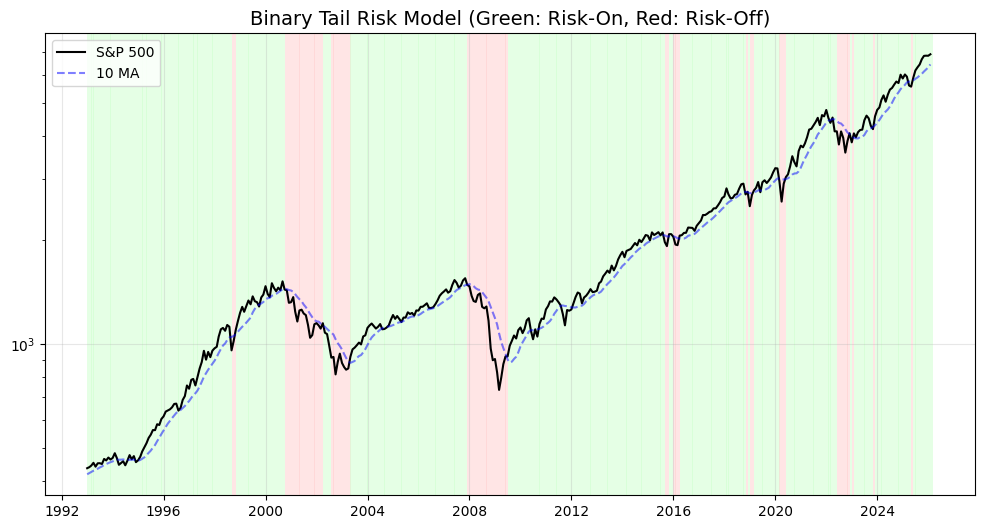

In [14]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

class BinaryRegimePipe:
    """
    [Binary Version]
    - Data: Stooq (Price) + FRED (Macro)
    - Logic: 2-State (Risk-On vs Risk-Off)
    - Philosophy: Remove 'Sideways'. Treat minor dips as noise (Stay Bull).
                  Only switch to Bear on 'Confirmed' signals.
    """
    def __init__(self, start_date='1990-01-01'):
        self.start = start_date
        self.end = datetime.today().strftime('%Y-%m-%d')
        self.df = pd.DataFrame()

    def fetch_data(self):
        print(f"--- [Binary Model] 데이터 수집 ({self.start} ~ {self.end}) ---")
        try:
            # 1. Price (Stooq)
            df_stock = web.DataReader('^SPX', 'stooq', self.start, self.end).sort_index()

            # 2. Macro (FRED)
            df_macro = web.DataReader(['VIXCLS', 'T10Y2Y'], 'fred', self.start, self.end)

            # Timezone Remove & Merge
            df_stock.index = df_stock.index.tz_localize(None)
            df_macro.index = df_macro.index.tz_localize(None)

            # Daily Merge -> Fill NaNs -> Monthly Resample
            df_daily = pd.concat([df_stock['Close'], df_macro], axis=1).ffill()

            df_monthly = pd.DataFrame()
            df_monthly['SP500'] = df_daily['Close'].resample('M').last()
            df_monthly['VIX'] = df_daily['VIXCLS'].resample('M').mean()
            df_monthly['Yield_Spread'] = df_daily['T10Y2Y'].resample('M').mean()

            self.df = df_monthly.dropna()
            print(f" -> 데이터 확보 완료: {len(self.df)}개월")
            return self.df

        except Exception as e:
            print(f"Error: {e}")
            return pd.DataFrame()

    def apply_binary_logic(self):
        """
        [2-State Logic]
        Sideways를 제거하고 Bull에 통합합니다.

        - Bear (0): 확실한 위기 신호 (추세 붕괴 + (공포 or 역전))
        - Bull (1): 그 외 모든 상황 (단순 하락이나 횡보는 버팀)
        """
        if self.df.empty: return

        # 1. 기술적 지표
        self.df['MA_10'] = self.df['SP500'].rolling(window=10).mean()

        # 2. Dynamic VIX Threshold (상대적 공포 기준)
        self.df['VIX_Threshold'] = self.df['VIX'].rolling(window=36).quantile(0.80)

        data = self.df.dropna().copy()
        regimes = []
        current_state = 1 # Start with Bull (Risk-On)

        for i in range(len(data)):
            row = data.iloc[i]

            # Conditions
            is_uptrend = row['SP500'] > row['MA_10']
            is_fear = row['VIX'] > row['VIX_Threshold']
            is_inverted = row['Yield_Spread'] < 0.0

            next_state = current_state

            # -------------------------------------------------------
            # [Binary Logic]
            # 1: Bull (Green) / 0: Bear (Red)
            # -------------------------------------------------------

            if current_state == 1: # [현재: Bull]
                # Bear로 전환되려면 까다로운 조건 필요 (Hysteresis)
                # 조건: 추세가 깨지고(AND) + (공포가 터지거나 OR 장단기 금리가 역전됨)
                # 즉, "이유 없는 하락"은 위기로 보지 않고 버팀.
                if not is_uptrend and (is_fear or is_inverted):
                    next_state = 0

            elif current_state == 0: # [현재: Bear]
                # Bull로 복귀하려면?
                # 조건: 추세만 회복하면 복귀 (V자 반등을 놓치지 않기 위함)
                if is_uptrend:
                    next_state = 1

            regimes.append(next_state)
            current_state = next_state

        data['Regime'] = regimes
        self.df = data
        return self.df

    def validate_performance(self):
        if 'Regime' not in self.df.columns: return

        self.df['Next_Ret'] = self.df['SP500'].pct_change().shift(-1)

        print("\n--- [Performance Check: 2-State Model] ---")
        # 1 = Bull, 0 = Bear
        stats = self.df.groupby('Regime')['Next_Ret'].agg(['count', 'mean', 'std'])

        stats['Ann_Return'] = stats['mean'] * 12 * 100
        stats['Ann_Vol'] = stats['std'] * (12**0.5) * 100
        stats['Sharpe'] = stats['Ann_Return'] / stats['Ann_Vol']

        label_map = {0: 'Bear (Cash)', 1: 'Bull (Equity)'}
        stats.index = stats.index.map(label_map)

        print(stats[['count', 'Ann_Return', 'Sharpe']].round(2))
        return stats

    def visualize(self):
        if self.df.empty: return

        df = self.df
        plt.figure(figsize=(12, 6))

        # 선 그래프
        plt.plot(df.index, df['SP500'], color='black', linewidth=1.5, label='S&P 500')
        plt.plot(df.index, df['MA_10'], color='blue', linestyle='--', alpha=0.5, label='10 MA')

        # 배경색 (Binary)
        # 0: Bear(Red), 1: Bull(Green)
        colors = {0: '#ffcccc', 1: '#ccffcc'}

        for i in range(len(df)):
            date = df.index[i]
            state = df['Regime'].iloc[i]
            # 한 달치 영역 칠하기
            plt.axvspan(date, date + pd.Timedelta(days=32),
                        facecolor=colors[state], edgecolor='none', alpha=0.5)

        plt.title('Binary Tail Risk Model (Green: Risk-On, Red: Risk-Off)', fontsize=14)
        plt.yscale('log')
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.show()

if __name__ == "__main__":
    pipe = BinaryRegimePipe()
    pipe.fetch_data()
    pipe.apply_binary_logic()
    pipe.validate_performance()
    pipe.visualize()

In [21]:
# Binary
bin_df = pipe.df.copy()
bin_df['Binary_Regime'] = bin_df['Regime']   # 1=Bull, 0=Bear
bin_df.index = bin_df.index.to_period('M').to_timestamp('M')

# HMM
hmm_df = labeled_df.copy()
hmm_df['HMM_Regime'] = hmm_df['Regime']      # 0=Bull,1=Uncertain,2=Crisis
hmm_df.index = hmm_df.index.to_period('M').to_timestamp('M')

# 공통 기간 Merge
cmp = bin_df[['SP500', 'Binary_Regime']] \
    .join(hmm_df[['HMM_Regime']], how='inner')



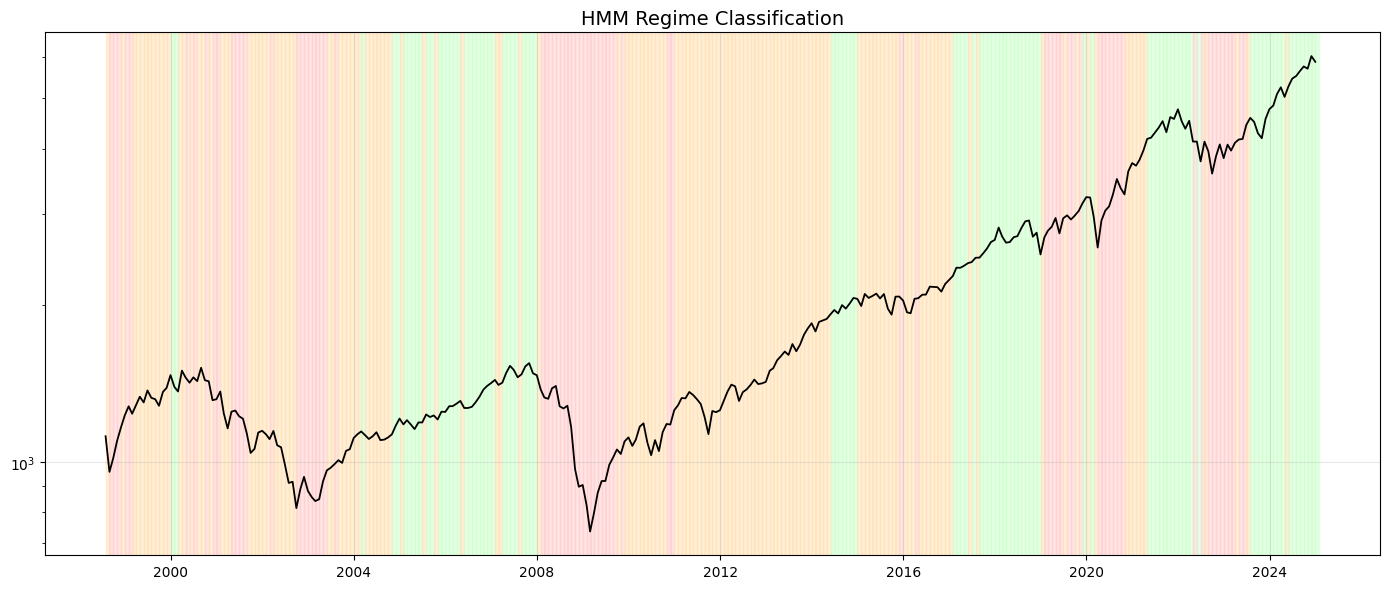

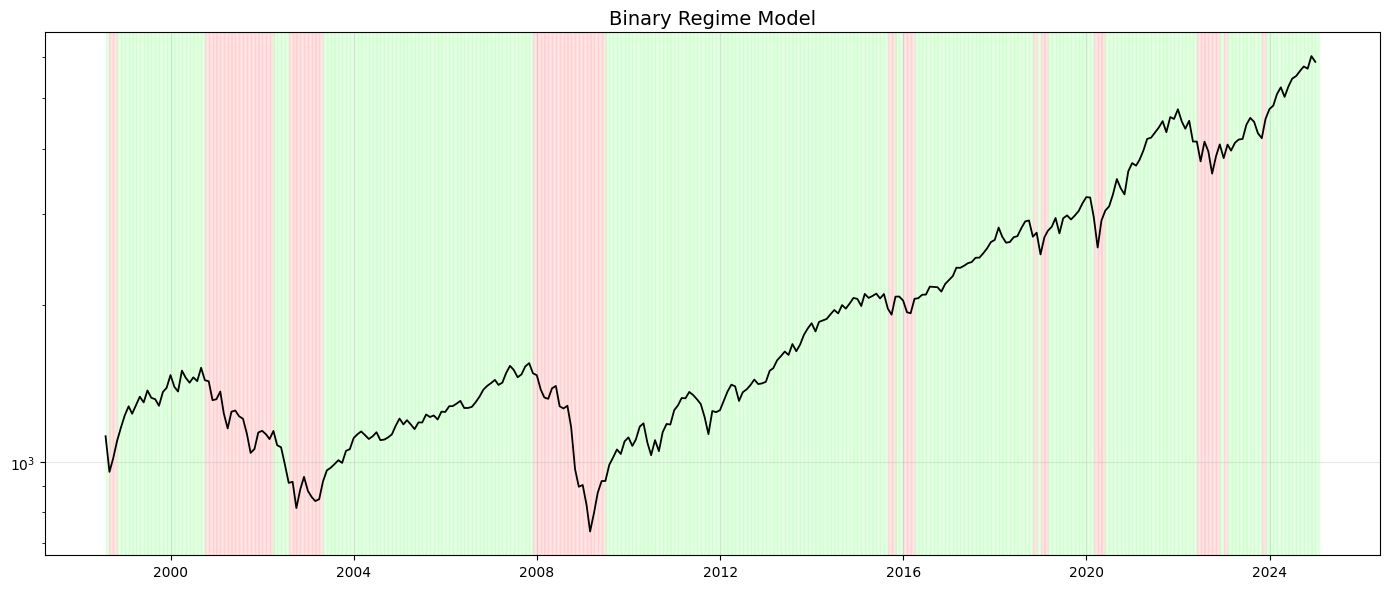

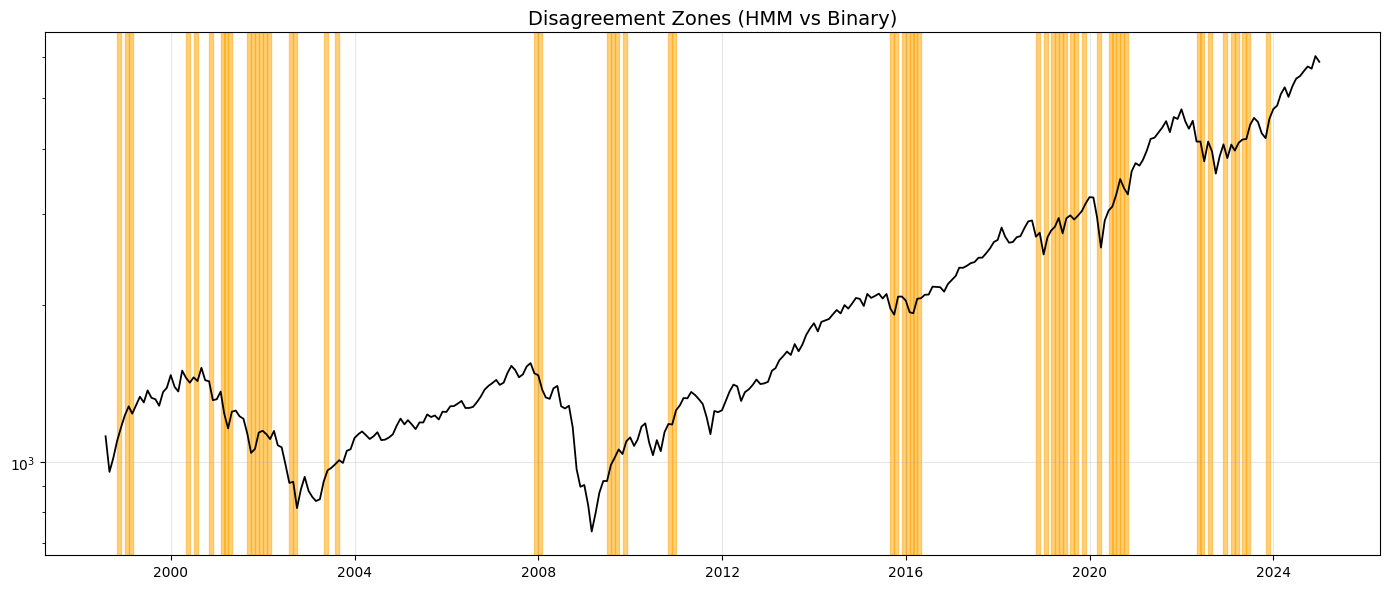

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(cmp.index, cmp['SP500'], color='black', linewidth=1.3)
ax.set_yscale('log')
ax.set_title('HMM Regime Classification', fontsize=14)

colors = {
    0: '#ccffcc',  # Bull
    1: '#ffe0b3',  # Uncertain
    2: '#ffcccc'   # Crisis
}

for i in range(len(cmp)):
    state = cmp['HMM_Regime'].iloc[i]
    ax.axvspan(
        cmp.index[i],
        cmp.index[i] + pd.Timedelta(days=32),
        color=colors[state],
        alpha=0.5,
        edgecolor='none'
    )

ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(cmp.index, cmp['SP500'], color='black', linewidth=1.3)
ax.set_yscale('log')
ax.set_title('Binary Regime Model', fontsize=14)

binary_colors = {
    1: '#ccffcc',  # Bull
    0: '#ffcccc'   # Bear
}

for i in range(len(cmp)):
    state = cmp['Binary_Regime'].iloc[i]
    ax.axvspan(
        cmp.index[i],
        cmp.index[i] + pd.Timedelta(days=32),
        color=binary_colors[state],
        alpha=0.5,
        edgecolor='none'
    )

ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Risk-Off 정의 통일
hmm_riskoff = (cmp['HMM_Regime'] == 2).astype(int)
bin_riskoff = (cmp['Binary_Regime'] == 0).astype(int)

disagree = hmm_riskoff != bin_riskoff
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(cmp.index, cmp['SP500'], color='black', linewidth=1.3)
ax.set_yscale('log')
ax.set_title('Disagreement Zones (HMM vs Binary)', fontsize=14)

for i in range(len(cmp)):
    if disagree.iloc[i]:
        ax.axvspan(
            cmp.index[i],
            cmp.index[i] + pd.Timedelta(days=32),
            color='orange',
            alpha=0.5,
            edgecolor='none'
        )

ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

